# Internship Task - 2

### Install and imnport the Lib

In [1]:
# !pip install -q kaggle
# !pip install -U keras-efficientnet-v2 -q

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from sklearn.model_selection import train_test_split
# import keras_efficientnet_v2
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from tensorflow.keras import metrics, optimizers, Sequential, activations, callbacks
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
import keras.backend as K
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

# Getting the data

In [3]:
# !rm -r ~/.kaggle
# !mkdir ~/.kaggle
# !mv ./kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [4]:
# !kaggle datasets download lexset/synthetic-asl-alphabet

In [5]:
# !unzip -qq "synthetic-asl-alphabet.zip" -d "synthetic-asl-alphabet"

In [6]:
train_dir = '/kaggle/input/synthetic-asl-alphabet/Train_Alphabet'
test_dir = '/kaggle/input/synthetic-asl-alphabet/Test_Alphabet'

In [7]:
def load_df(dir_path):
    df = {
        'filename': [],
        'label': []
    }
    classes = os.listdir(dir_path)
    for c in classes:
        path = dir_path + '/' + c

        img_paths = os.listdir(path)

        for img_path in img_paths:
            df['filename'].append(c + '/' + img_path)
            df['label'].append(c)
        
    df = pd.DataFrame(df)
    return df

train_df = load_df(train_dir)
test_df = load_df(test_dir)

In [8]:
train_df.sample(5)

,filename,label
8944,X/8e5d20e5-109c-4bd7-9e66-8f0d1b16080f.rgb_000...,X
6525,U/998bfaa6-0fd4-495a-b66c-0e522864baca.rgb_000...,U
4929,H/885c0cf6-84e0-4cfa-ad2e-523a4d7b4467.rgb_000...,H
8918,X/a94d77e6-1fdf-4fc0-bc7a-0a04e15db8d5.rgb_000...,X
10763,Q/0d99d487-da2f-4fc8-9521-a88dcd75283c.rgb_000...,Q


# Split train-valid

In [9]:
X = train_df['filename']
y = train_df['label']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, random_state=1, test_size=0.2)
print(X_train.shape)
print(X_valid.shape)

(19440,)
(4860,)


In [10]:
train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)
test = test_df

In [11]:
train['label'].value_counts()

E        720
K        720
O        720
M        720
X        720
P        720
N        720
B        720
W        720
S        720
Z        720
V        720
G        720
D        720
Y        720
J        720
L        720
U        720
A        720
C        720
R        720
H        720
Blank    720
I        720
T        720
F        720
Q        720
Name: label, dtype: int64

In [12]:
valid['label'].value_counts()

C        180
B        180
A        180
G        180
X        180
I        180
K        180
Y        180
P        180
H        180
T        180
O        180
U        180
E        180
J        180
L        180
Q        180
V        180
M        180
R        180
S        180
F        180
D        180
W        180
Blank    180
N        180
Z        180
Name: label, dtype: int64

In [13]:
test['label'].value_counts()

N        100
S        100
D        100
W        100
L        100
P        100
C        100
Z        100
V        100
T        100
O        100
A        100
G        100
Blank    100
R        100
Y        100
Q        100
K        100
X        100
M        100
U        100
E        100
H        100
F        100
I        100
B        100
J        100
Name: label, dtype: int64

In [14]:
IMAGE_SIZE = (224, 224)

datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
#     brightness_range=[0.5, 1.0],
)

train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_dir,
    x_col='filename',
    y_col='label',
    batch_size=32,
    # color_mode="rgb",
    seed=42,
    shuffle=True,
    class_mode='sparse',
    target_size=IMAGE_SIZE
)

valid_generator=datagen.flow_from_dataframe(
    dataframe=valid,
    directory=train_dir,
    x_col="filename",
    y_col="label",
    batch_size=32,
    # color_mode="rgb",
    seed=42,
    shuffle=True,
    class_mode="sparse",
    target_size=IMAGE_SIZE
)

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=test_dir,
    x_col="filename",
    y_col=None,
    batch_size=1,
    # color_mode="rgb",
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=IMAGE_SIZE
)

Found 19440 validated image filenames belonging to 27 classes.
Found 4860 validated image filenames belonging to 27 classes.
Found 2700 validated image filenames.


# EfficientNetV2B0

## Training

In [15]:
tf.keras.backend.clear_session()
num_classes = 27

backbone = tf.keras.applications.EfficientNetB0(include_top=False)
backbone.trainable = False

inputs = Input(shape=IMAGE_SIZE + (3,), name='inputs')
x = backbone(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
# x = Dense(100, activation='relu')(x)
outputs = Dense(27, activation='softmax')(x)

model_efficientnet = tf.keras.Model(inputs=inputs, outputs=outputs, name='efficientnet_model')
model_efficientnet.summary()

2023-01-06 08:32:48.777776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 08:32:48.889253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 08:32:48.890088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 08:32:48.891464: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

16719872/16705208 [==============================] - 0s 0us/step
Model: "efficientnet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 27)                34587     
Total params: 4,084,158
Trainable params: 34,587
Non-trainable params: 4,049,571
_________________________________________________________________


In [16]:
tf.keras.backend.clear_session()
num_classes = 27
model_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2'

feature_extractor_layer = hub.KerasLayer(model_url,
                                         trainable=False, # freeze the underlying patterns
                                         name='feature_extraction_layer',
                                         input_shape=IMAGE_SIZE + (3,))
# Create our own model
# inputs = Input(shape=IMAGE_SIZE + (3,), name='inputs')
# x = feature_extractor_layer(inputs, training=False)
# x = Dropout(0.2)(x)
# outputs = Dense(27, activation='softmax')(x)

# model_efficientnet = tf.keras.Model(inputs=inputs, outputs=outputs, name='efficientnet_model')

model_efficientnet = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    Dropout(0.2),
    Dense(num_classes, activation='softmax') # create our own output layer      
])

model_efficientnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              5919312   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 27)                34587     
Total params: 5,953,899
Trainable params: 34,587
Non-trainable params: 5,919,312
_________________________________________________________________


In [17]:
model_efficientnet.compile(optimizer=keras.optimizers.Adam(),
                           loss='sparse_categorical_crossentropy',
                           metrics=["accuracy"])

In [18]:
cb = [
#     callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint('model_efficientnet.h5', save_best_only=True, monitor='val_loss')
]

history_efficientnet = model_efficientnet.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 20,
    batch_size = 32,
    verbose = 1,
    callbacks = cb
)

2023-01-06 08:33:01.502070: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2023-01-06 08:33:09.749165: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


608/608 [==============================] - 714s 1s/step - loss: 1.7488 - accuracy: 0.5698 - val_loss: 1.0928 - val_accuracy: 0.7626
Epoch 2/20
608/608 [==============================] - 493s 811ms/step - loss: 0.9571 - accuracy: 0.7684 - val_loss: 0.8192 - val_accuracy: 0.8109
Epoch 3/20
608/608 [==============================] - 491s 808ms/step - loss: 0.7490 - accuracy: 0.8134 - val_loss: 0.6701 - val_accuracy: 0.8451
Epoch 4/20
608/608 [==============================] - 499s 821ms/step - loss: 0.6413 - accuracy: 0.8355 - val_loss: 0.6055 - val_accuracy: 0.8486
Epoch 5/20
608/608 [==============================] - 487s 801ms/step - loss: 0.5730 - accuracy: 0.8519 - val_loss: 0.5650 - val_accuracy: 0.8562
Epoch 6/20
608/608 [==============================] - 486s 799ms/step - loss: 0.5229 - accuracy: 0.8580 - val_loss: 0.5226 - val_accuracy: 0.8599
Epoch 7/20
608/608 [==============================] - 481s 791ms/step - loss: 0.4897 - accuracy: 0.8673 - val_loss: 0.4817 - val_accuracy:

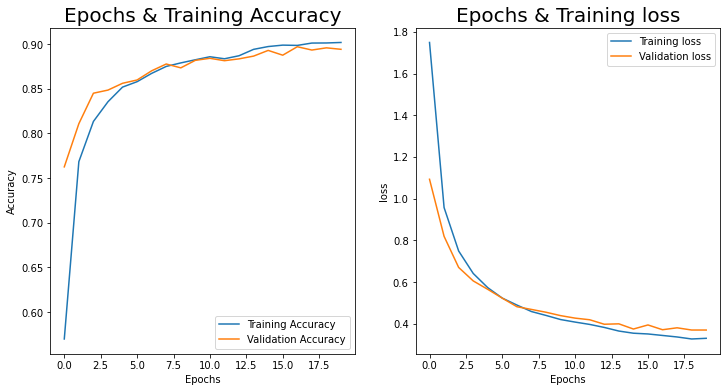

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(history_efficientnet.history['accuracy'], '-', label = 'Training Accuracy')
ax[0].plot(history_efficientnet.history['val_accuracy'], '-', label = 'Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(history_efficientnet.history['loss'], '-', label = 'Training loss')
ax[1].plot(history_efficientnet.history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

In [20]:
model_loaded = model_efficientnet

In [21]:
test_generator.reset()
pred = model_loaded.predict(test_generator, verbose=1)

2700/2700 [==============================] - 65s 24ms/step


In [22]:
pred = np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

print(accuracy_score(test['label'], pred))
print(classification_report(test['label'], pred))

0.9222222222222223
              precision    recall  f1-score   support

           A       0.94      0.97      0.96       100
           B       0.99      0.92      0.95       100
       Blank       1.00      0.98      0.99       100
           C       0.99      0.98      0.98       100
           D       0.94      0.88      0.91       100
           E       0.91      0.94      0.93       100
           F       0.94      0.94      0.94       100
           G       0.91      0.96      0.93       100
           H       0.98      1.00      0.99       100
           I       0.91      0.89      0.90       100
           J       0.86      0.93      0.89       100
           K       0.94      0.88      0.91       100
           L       0.98      0.94      0.96       100
           M       0.80      0.90      0.85       100
           N       0.87      0.82      0.85       100
           O       0.97      0.99      0.98       100
           P       0.92      0.95      0.94       100
        

## Fine-tuning

In [23]:
feature_extractor_layer.trainable = True

model_efficientnet.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                           loss='sparse_categorical_crossentropy',
                           metrics=["accuracy"])

In [24]:
cb = [
#     callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint('model_efficientnet_finetuned.h5', save_best_only=True, monitor='val_loss')
]

train_generator.reset()
valid_generator.reset()

history_efficientnet_2 = model_efficientnet.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 10,
    batch_size = 32,
    verbose = 1,
    callbacks = cb
)

Epoch 1/10
608/608 [==============================] - 518s 834ms/step - loss: 1.2017 - accuracy: 0.6690 - val_loss: 0.2236 - val_accuracy: 0.9292
Epoch 2/10
608/608 [==============================] - 526s 866ms/step - loss: 0.3864 - accuracy: 0.8756 - val_loss: 0.0874 - val_accuracy: 0.9753
Epoch 3/10
608/608 [==============================] - 554s 911ms/step - loss: 0.2046 - accuracy: 0.9336 - val_loss: 0.0442 - val_accuracy: 0.9858
Epoch 4/10
608/608 [==============================] - 534s 879ms/step - loss: 0.1134 - accuracy: 0.9632 - val_loss: 0.0265 - val_accuracy: 0.9922
Epoch 5/10
608/608 [==============================] - 527s 867ms/step - loss: 0.0789 - accuracy: 0.9738 - val_loss: 0.0195 - val_accuracy: 0.9947
Epoch 6/10
608/608 [==============================] - 525s 864ms/step - loss: 0.0608 - accuracy: 0.9801 - val_loss: 0.0158 - val_accuracy: 0.9953
Epoch 7/10
608/608 [==============================] - 526s 864ms/step - loss: 0.0431 - accuracy: 0.9857 - val_loss: 0.0119 -

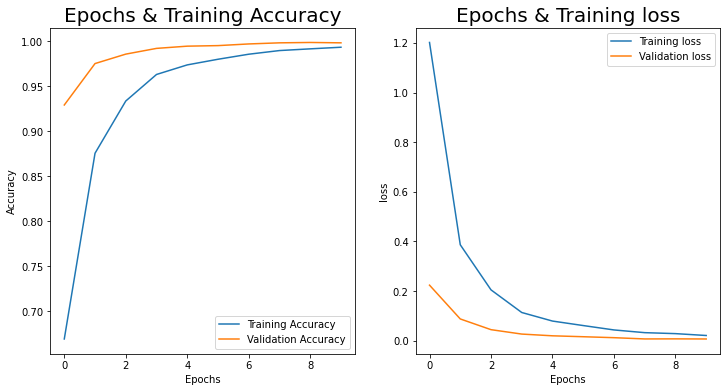

In [25]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(history_efficientnet_2.history['accuracy'], '-', label = 'Training Accuracy')
ax[0].plot(history_efficientnet_2.history['val_accuracy'], '-', label = 'Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(history_efficientnet_2.history['loss'], '-', label = 'Training loss')
ax[1].plot(history_efficientnet_2.history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

In [26]:
model_loaded = model_efficientnet

In [27]:
test_generator.reset()
pred = model_loaded.predict(test_generator, verbose=1)

2700/2700 [==============================] - 51s 19ms/step


In [28]:
pred = np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

print(accuracy_score(test['label'], pred))
print(classification_report(test['label'], pred))

0.9992592592592593
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       100
           B       1.00      1.00      1.00       100
       Blank       1.00      1.00      1.00       100
           C       1.00      1.00      1.00       100
           D       1.00      1.00      1.00       100
           E       1.00      1.00      1.00       100
           F       1.00      1.00      1.00       100
           G       0.98      1.00      0.99       100
           H       1.00      1.00      1.00       100
           I       1.00      1.00      1.00       100
           J       1.00      0.99      0.99       100
           K       1.00      1.00      1.00       100
           L       1.00      1.00      1.00       100
           M       1.00      1.00      1.00       100
           N       1.00      1.00      1.00       100
           O       1.00      1.00      1.00       100
           P       1.00      1.00      1.00       100
        